In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
def preprocess_data(df, target_col=None, le_dict=None, scaler=None):
    # Handle missing values
    # Technially not nesessary for this data because we have no null values, but if we did
    # this will replace the null value with the median or mode
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Encode categorical features
    if le_dict is None:  # creates encoders
        le_dict = {}
        for col in df.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            le_dict[col] = le
    else:  # Uses the encoders from the first dataset on the second so that the categorical values match
        for col in df.select_dtypes(include=['object']).columns:
            if col in le_dict:
                df[col] = le_dict[col].transform(df[col])
            else:
                raise ValueError(f"Unexpected categorical column: {col}")

    # Separate features and target
    if target_col and target_col in df.columns:
        X = df.drop(columns=[target_col], axis=1)
        y = df[[target_col]]
    else:
        X = df.copy()
        y = None

    # Standardize numerical features (exclude target if present)
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    if scaler is None:  # first dataset: fit scaler
        scaler = StandardScaler()
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    else:  # second dataset: use existing scaler
        X[numeric_cols] = scaler.transform(X[numeric_cols])

    return X, y, le_dict, scaler


In [3]:
#read in files
adult = pd.read_csv('project_adult.csv')
validation_inputs = pd.read_csv('project_validation_inputs.csv')

In [4]:
#actually preprocess the data
X_train, y_train, le_dict, scaler = preprocess_data(adult, target_col = "income")
X_test, y2, _, _ = preprocess_data(validation_inputs, target_col = "income", le_dict=le_dict, scaler=scaler)

In [5]:
model_lr = LogisticRegression(solver='lbfgs', random_state = 42, max_iter = 200)
model_lr.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=200, random_state=42)

In [6]:
y_pred = model_lr.predict(X_test)

In [7]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
# np.logspace(-4,4,2-) tells GridSearchCV to test 20 values for C eenly spaced on logarithmic scale from 10^-4 to 10^4
param_grid = {
    'C': [0.01,1,100],  # Inverse of regularization strength
}

# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', random_state=42, max_iter=200),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train, y_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200, random_state=42),
             n_jobs=-1, param_grid={'C': [0.01, 1, 100]}, scoring='accuracy',
             verbose=1)

In [8]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1}
Best cross-validation accuracy: 0.8242


In [9]:
y_val_predicted = best_model.predict(X_test)
validation_inputs["predicted_income"] = y_val_predicted
print(validation_inputs["predicted_income"].head())

0    0
1    0
2    0
3    0
4    0
Name: predicted_income, dtype: int64


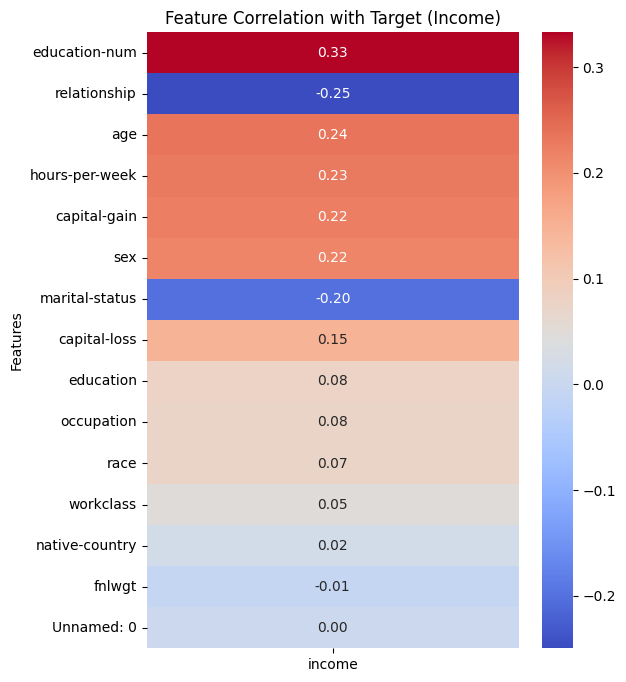

In [10]:
# Combine features and target
df_corr = pd.concat([X_train, y_train], axis=1)

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Extract correlation of each feature with the target
feature_corr = corr_matrix[["income"]].drop("income")  # drop the target itself

# Sort features by absolute correlation (optional, makes it easier to read)
feature_corr_sorted = feature_corr.reindex(feature_corr["income"].abs().sort_values(ascending=False).index)

# Plot heatmap
plt.figure(figsize=(6, 8))  # adjust figure size for readability
sns.heatmap(feature_corr_sorted, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Feature Correlation with Target (Income)")
plt.ylabel("Features")
plt.show()

In [11]:
def plot_logreg_edu_relationship(model, X, y):
    """
    Plots the decision boundary for a logistic regression model
    using only 'education-num' and 'relationship'.
    
    Args:
        model: a trained LogisticRegression model (fitted on X)
        X (pd.DataFrame): input features
        y (pd.Series or DataFrame): target labels
    """
    # Ensure y is a Series
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If y is a DataFrame, it must have a single column.")
        y_series = y.iloc[:, 0]
    else:
        y_series = pd.Series(y).ravel()

    # Encode target if needed
    if y_series.dtype == 'object':
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    # Select only the two features
    features = ["education-num", "relationship"]
    X_pair = X[features].copy()

    # Retrain a logistic regression model on these two features
    logreg = LogisticRegression(
        C=model.C if hasattr(model, 'C') else 1.0,
        max_iter=1000,
        solver='lbfgs'
    )
    logreg.fit(X_pair.values, y_encoded)

    # Create meshgrid
    x_min, x_max = X_pair["education-num"].min() - 1, X_pair["education-num"].max() + 1
    y_min, y_max = X_pair["relationship"].min() - 1, X_pair["relationship"].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    # Predict on meshgrid
    Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_pair["education-num"], X_pair["relationship"], c=y_encoded, cmap=plt.cm.coolwarm,
                s=50, edgecolor='k')
    plt.xlabel("education-num")
    plt.ylabel("relationship")
    plt.title("Logistic Regression Decision Boundary\n(education-num vs relationship)")
    plt.show()


In [14]:
def plot_logreg_age_capitalgain(model, X, y):
    """
    Plots the decision boundary for a logistic regression model
    using only 'age' and 'capital-gain'.
    
    Args:
        model: a trained LogisticRegression model (fitted on X)
        X (pd.DataFrame): input features
        y (pd.Series or DataFrame): target labels
    """
    # Ensure y is a Series
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If y is a DataFrame, it must have a single column.")
        y_series = y.iloc[:, 0]
    else:
        y_series = pd.Series(y).ravel()

    # Encode target if needed
    if y_series.dtype == 'object':
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    # Select only the two features
    features = ["age", "capital-gain"]
    X_pair = X[features].copy()

    # Retrain a logistic regression model on these two features
    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression(
        C=model.C if hasattr(model, 'C') else 1.0,
        max_iter=1000,
        solver='lbfgs'
    )
    logreg.fit(X_pair.values, y_encoded)

    # Create meshgrid
    x_min, x_max = X_pair["age"].min() - 1, X_pair["age"].max() + 1
    y_min, y_max = X_pair["capital-gain"].min() - 1, X_pair["capital-gain"].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    # Predict on meshgrid
    Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_pair["age"], X_pair["capital-gain"], c=y_encoded, cmap=plt.cm.coolwarm,
                s=50, edgecolor='k')
    plt.xlabel("Age")
    plt.ylabel("Capital Gain")
    plt.title("Logistic Regression Decision Boundary\n(Age vs Capital Gain)")
    plt.show()


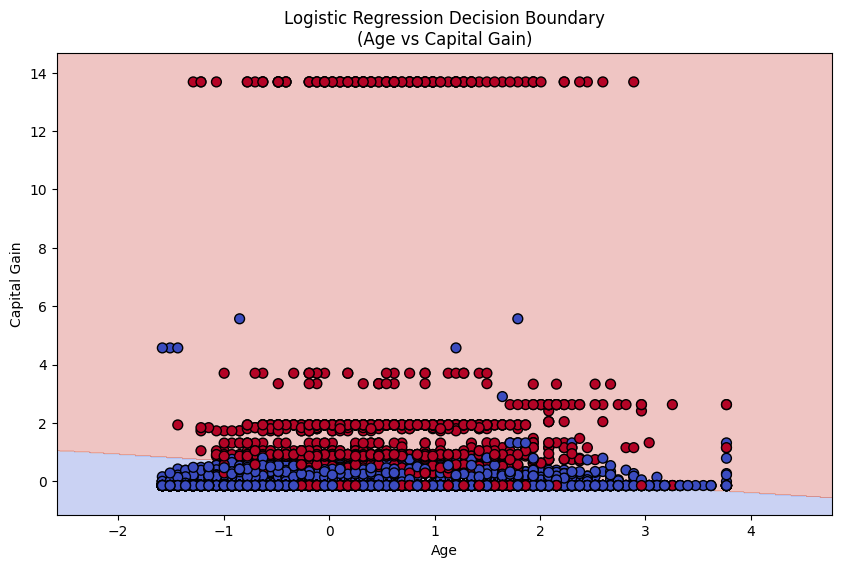

In [15]:
plot_logreg_age_capitalgain(grid_search, X_train, y_train)

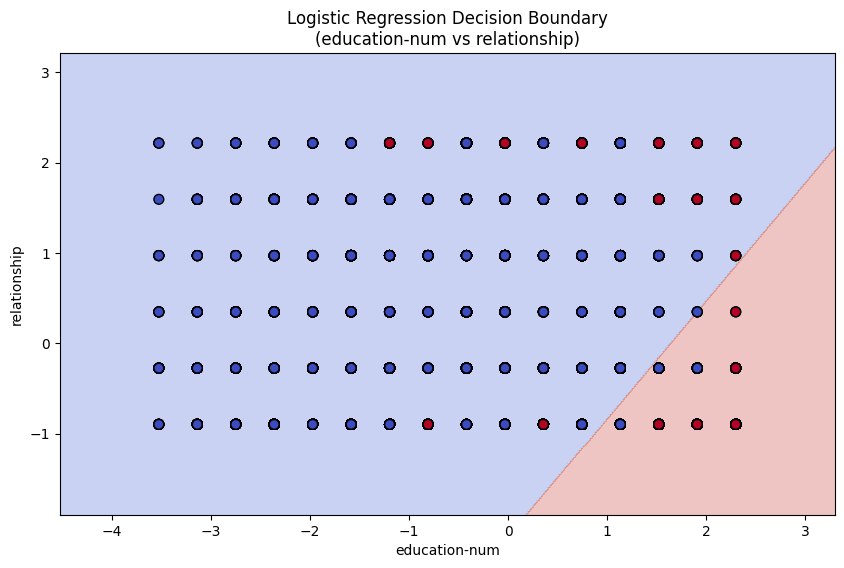

In [12]:
plot_logreg_edu_relationship(grid_search, X_train, y_train)

In [ ]:
def logreg_c_test(X, y):
    """
    Trains Logistic Regression models with different C values
    and plots training and testing accuracies.
    """
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Candidate C values
    C_values = [0.01, 1, 100]
    train_accuracies = []
    test_accuracies = []

    for C in C_values:
        # Train logistic regression
        logreg = LogisticRegression(C=C, max_iter=1000, solver='lbfgs')
        logreg.fit(X_train, y_train)

        # Evaluate
        train_acc = accuracy_score(y_train, logreg.predict(X_train))
        test_acc = accuracy_score(y_test, logreg.predict(X_test))

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"C={C}: Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(C_values, train_accuracies, marker='o', linestyle='--', label="Train Accuracy")
    plt.plot(C_values, test_accuracies, marker='s', linestyle='-', label="Test Accuracy")
    plt.xscale("log")  # log scale for clarity
    plt.xlabel("C (Inverse Regularization Strength)")
    plt.ylabel("Accuracy")
    plt.title("Effect of C on Logistic Regression Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C=0.01: Train Accuracy = 0.8221, Test Accuracy = 0.8269
C=1: Train Accuracy = 0.8240, Test Accuracy = 0.8267
C=100: Train Accuracy = 0.8240, Test Accuracy = 0.8265


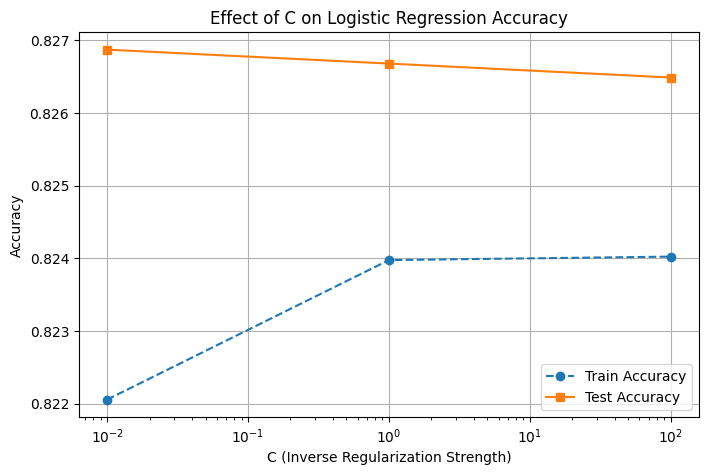

In [19]:
logreg_c_test(X_train, y_train)
